In [1]:
import sys
sys.path.append("../src")

import os
from pathlib import Path
from typing import List, Tuple

# Third-Party Imports
import cv2
import pyvips
import tifffile
import numpy as np
from tqdm import tqdm
from empatches import EMPatches
import matplotlib.pyplot as plt

# Local Imports
from utils import get_args, save_patch_args

/Users/ericmonzon/mambaforge/envs/histology/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
data_dir = os.path.join("..", "..", "raw-data", "patches-test", "experiment-0", "10490")
img_names = os.listdir(data_dir)

print("num images:", len(img_names))

num images: 16686


In [14]:
def extract_coords(img_name: List[str]):

    stem = Path(img_name).stem
    y1, y2, x1, x2 = [int(c) for c in stem.split("-")[1:]]
    coords = (y1, y2, x1, x2)

    return coords


def adjust_coords(
    coords: List[int], 
    src_patch_size: int, 
    target_patch_size: int
    ):

    scaling_factor = src_patch_size / target_patch_size

    adjusted_coords = []

    for coord in coords:
        adjusted = [int(c / scaling_factor) for c in coord]

        adjusted_coords.append(adjusted)

    return adjusted_coords

In [15]:
img_paths = [os.path.join(data_dir, i) for i in img_names]
img_patches = [pyvips.Image.new_from_file(f).numpy() for f in img_paths]

new_size = (32, 32)
resized_image_patches = [cv2.resize(image, new_size) for image in img_patches]

In [16]:
coords = [extract_coords(path) for path in img_paths]

coords

[(30016, 30240, 26208, 26432),
 (29568, 29792, 26432, 26656),
 (29792, 30016, 26432, 26656),
 (30016, 30240, 26432, 26656),
 (30240, 30464, 26432, 26656),
 (30464, 30688, 26432, 26656),
 (27328, 27552, 26656, 26880),
 (28000, 28224, 26656, 26880),
 (28224, 28448, 26656, 26880),
 (28448, 28672, 26656, 26880),
 (28672, 28896, 26656, 26880),
 (28896, 29120, 26656, 26880),
 (29120, 29344, 26656, 26880),
 (29344, 29568, 26656, 26880),
 (29568, 29792, 26656, 26880),
 (29792, 30016, 26656, 26880),
 (30016, 30240, 26656, 26880),
 (30240, 30464, 26656, 26880),
 (30464, 30688, 26656, 26880),
 (27104, 27328, 26880, 27104),
 (27328, 27552, 26880, 27104),
 (27552, 27776, 26880, 27104),
 (27776, 28000, 26880, 27104),
 (28000, 28224, 26880, 27104),
 (28224, 28448, 26880, 27104),
 (28448, 28672, 26880, 27104),
 (28672, 28896, 26880, 27104),
 (28896, 29120, 26880, 27104),
 (29120, 29344, 26880, 27104),
 (29344, 29568, 26880, 27104),
 (29568, 29792, 26880, 27104),
 (29792, 30016, 26880, 27104),
 (30016,

In [17]:
adjusted_coords = adjust_coords(coords, 224, 32)

adjusted_coords

[[4288, 4320, 3744, 3776],
 [4224, 4256, 3776, 3808],
 [4256, 4288, 3776, 3808],
 [4288, 4320, 3776, 3808],
 [4320, 4352, 3776, 3808],
 [4352, 4384, 3776, 3808],
 [3904, 3936, 3808, 3840],
 [4000, 4032, 3808, 3840],
 [4032, 4064, 3808, 3840],
 [4064, 4096, 3808, 3840],
 [4096, 4128, 3808, 3840],
 [4128, 4160, 3808, 3840],
 [4160, 4192, 3808, 3840],
 [4192, 4224, 3808, 3840],
 [4224, 4256, 3808, 3840],
 [4256, 4288, 3808, 3840],
 [4288, 4320, 3808, 3840],
 [4320, 4352, 3808, 3840],
 [4352, 4384, 3808, 3840],
 [3872, 3904, 3840, 3872],
 [3904, 3936, 3840, 3872],
 [3936, 3968, 3840, 3872],
 [3968, 4000, 3840, 3872],
 [4000, 4032, 3840, 3872],
 [4032, 4064, 3840, 3872],
 [4064, 4096, 3840, 3872],
 [4096, 4128, 3840, 3872],
 [4128, 4160, 3840, 3872],
 [4160, 4192, 3840, 3872],
 [4192, 4224, 3840, 3872],
 [4224, 4256, 3840, 3872],
 [4256, 4288, 3840, 3872],
 [4288, 4320, 3840, 3872],
 [4320, 4352, 3840, 3872],
 [4352, 4384, 3840, 3872],
 [4384, 4416, 3840, 3872],
 [6464, 6496, 3840, 3872],
 

In [18]:
def merge_patches(patches, coords):
    orig_height = 384 * 32
    orig_width = 384 * 32
    
    num_channels = patches[0].shape[-1]
    merged_img = np.zeros((orig_height, orig_width, num_channels), dtype=np.float32)

    for i, coord in enumerate(coords):
        merged_img[coord[0] : coord[1], coord[2] : coord[3], :] = patches[i]

    return merged_img

In [19]:
merged = merge_patches(resized_image_patches, adjusted_coords).astype("uint8")

In [23]:
merged.shape

(12288, 12288, 3)

In [24]:
merged.dtype

dtype('uint8')

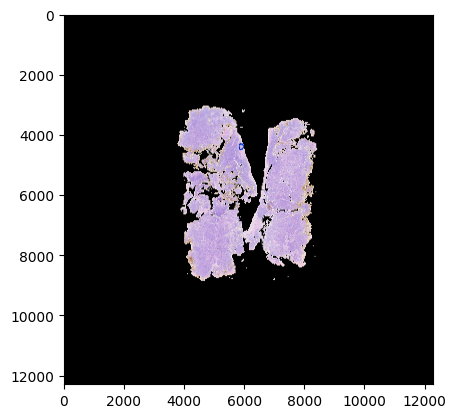

In [25]:
plt.imshow(merged)
plt.show()

In [12]:
plt.imsave("test.png", merged.astype("uint8"))